# BART fine-tuning with AdamW-paged8bit

**Goal** : Overall SARI score **49.47518782709121**

- warmup steps: 2
- training epochs: 3
- learning rate: 2e-5

> Best SARI score: 48.66193435869

- generation config setup
  
> Best SARI score:  **48.83351591353965**

#### Experiments:

(1)

- increase warmup steps -> 192
- increase training epochs -> 6

>Overall SARI score:  47.81503821900098


(2)

- increase warmup steps -> 96
- training epochs -> 3
- lower the learning rate -> 1e-5

>Overall SARI score: 47.85985224335648

(3)

- increase warmup steps -> 96
- training epochs -> 3
- learning rate -> 2e-5

>Overall SARI score: 48.05033978194464


(4)

- add generation-config setup:

> Overall SARI score: 48.603192398164055

(5)

- add generation-config setup
- add BART config setup

> Overall SARI score:  26.33783988994998


# Load dataset

Data:

- swipe_train.json
- swipe_val.json
- swipe_test_id.json -> in-domain test set
- swipe_test_ood.json -> out of domain test set

# Load BART-large Model 

BART https://huggingface.co/docs/transformers/v4.44.2/en/model_doc/bart

bart-large

In [1]:
from transformers import BartTokenizer, BartForConditionalGeneration
import torch

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large', use_fast=True)
model =  BartForConditionalGeneration.from_pretrained('facebook/bart-large', device_map ={'':torch.cuda.current_device()})

In [2]:
# number of trainable parameters
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {trainable_parameters}")

Total number of trainable parameters: 406291456


# Tokenize dataset

In [9]:
def tokenize_func(examples):
    # inputs
    inputs = tokenizer(examples['r_content'], truncation=True, padding="max_length", max_length=512)
    # labels
    labels = tokenizer(examples['s_content'], truncation=True, padding="max_length", max_length=512)
    # set the labels in the input dictionary
    inputs['labels'] = labels['input_ids']
    return inputs

tokenized_datasets = swipe_dataset.map(tokenize_func, batched=True)
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/3847 [00:00<?, ? examples/s]

Map:   0%|          | 0/479 [00:00<?, ? examples/s]

Map:   0%|          | 0/483 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

In [10]:
tokenized_datasets.save_to_disk("../data/tokenized_swipe_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/3847 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/479 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/483 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/368 [00:00<?, ? examples/s]

# Train the model

Category Classification Models:

- batch-size: 6
- apex: half-precision
- epochs: 7
- learning rate: 10^−5

In [3]:
from datasets import load_from_disk

tokenized_datasets = load_from_disk("../data/tokenized_swipe_dataset")

## Check memory usage

In [14]:
!du -sh ../main/*

36K	../main/BART_finetuning.ipynb
108K	../main/BART-SWiPE.ipynb
12K	../main/datasets.ipynb
8.0K	../main/ragsimp.ipynb
2.0M	../main/swipe-clean.ipynb


In [15]:
!du -sh ../data/*

536K	../data/bert_scores_test_id.csv
1.6M	../data/bert_scores_test_ood.csv
4.7M	../data/bert_scores_train.csv
604K	../data/bert_scores_val.csv
4.0K	../data/folder_download.ipynb
45M	../data/swipe_clean
8.8M	../data/swipe_generator_data.json
2.2M	../data/swipe_test_id.json
4.4M	../data/swipe_test_ood.json
18M	../data/swipe_train.json
2.3M	../data/swipe_val.json
528K	../data/test_id_df_cleaned.csv
580K	../data/test_ood_df_cleaned.csv
39M	../data/tokenized_swipe_dataset
4.0M	../data/train_df_cleaned.csv
512K	../data/val_df_cleaned.csv


In [3]:
!nvidia-smi

Fri Sep  6 09:43:33 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:3D:00.0 Off |                    0 |
| N/A   43C    P0    62W / 300W |    579MiB / 16384MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:3E:00.0 Off |                    0 |
| N/A   

In [5]:
import torch

torch.cuda.empty_cache()

if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory
    gpu_memory_in_use = torch.cuda.memory_allocated(0)
    gpu_memory_free = torch.cuda.memory_reserved(0)
    
    print(f"Total GPU Memory: {gpu_memory / 1e9:.2f} GB")
    print(f"Memory in Use: {gpu_memory_in_use / 1e9:.2f} GB")
    print(f"Free Memory: {gpu_memory_free / 1e9:.2f} GB")
else:
    print("CUDA is not available")

Total GPU Memory: 99.87 GB
Memory in Use: 1.63 GB
Free Memory: 1.64 GB


# Training

>based on validation
loss, which reached 1.12 for BART-SWIPE and
0.78 for BART-SWIPE-C.

In [6]:
# per_device_train_batch_size = 6
# num_train_epochs = 3
total_steps = (len(tokenized_datasets['train']) // 6) * 3
print("Total steps: " ,total_steps)
warmup_steps = int(total_steps * 0.05) 
print("Warmup steps: ", warmup_steps)

Total steps:  1923
Warmup steps:  96


In [4]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers.integrations import TensorBoardCallback

training_args = TrainingArguments(
    output_dir="../models/bart-swipe/results-adam-paged8bit",
    eval_strategy="epoch", 
    save_strategy = "epoch", 
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=2e-5, 
    per_device_train_batch_size=6, # 6 -> 4 2 
    per_device_eval_batch_size=6, # 6 -> 4 2
    num_train_epochs=3, # 3 -> 6
    weight_decay=0.01,
    save_total_limit=3, 
    #gradient_accumulation_steps=6, # reduce memory
    load_best_model_at_end=True, # based on valid loss
    warmup_steps = 2,
    optim = "paged_adamw_8bit", # optimizer for quantization
    fp16=True, # enable half-precision
    logging_dir='../models/bart-swipe/logs-adam-paged8bit'
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# silence warnings
model.config.use_cache = False

In [8]:
trainer.evaluate()

{'eval_loss': 18.412118911743164,
 'eval_runtime': 4.0735,
 'eval_samples_per_second': 117.59,
 'eval_steps_per_second': 19.639}

In [5]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.183300,0.180293
2,0.267200,0.175997
3,0.130400,0.175997


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warni

TrainOutput(global_step=1926, training_loss=0.6301880930381153, metrics={'train_runtime': 224.9348, 'train_samples_per_second': 51.308, 'train_steps_per_second': 8.562, 'total_flos': 1.2505277106487296e+16, 'train_loss': 0.6301880930381153, 'epoch': 3.0})

# Visualize training process

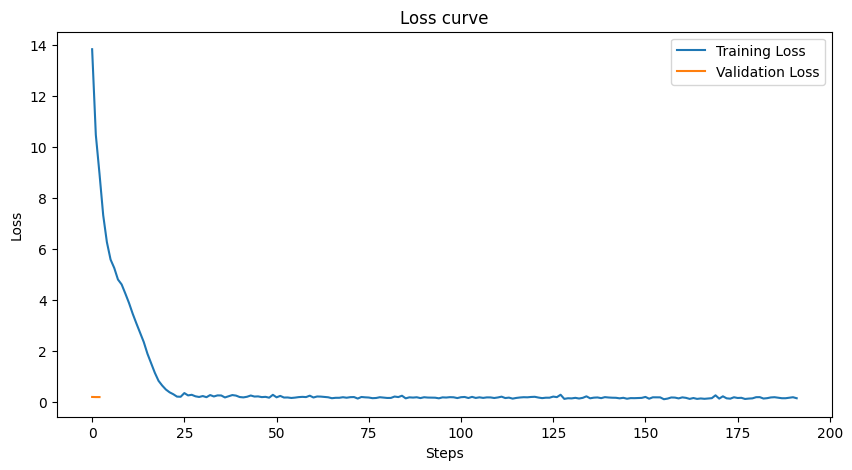

In [6]:
import matplotlib.pyplot as plt

# loss values from the log history
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
steps = range(len(train_loss))

plt.figure(figsize=(10,5))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps[:len(eval_loss)], eval_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.legend()
plt.show()

In [7]:
# reenable the warnings
model.config.use_cache = True

In [8]:
import torch

if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory
    gpu_memory_in_use = torch.cuda.memory_allocated(0)
    gpu_memory_free = torch.cuda.memory_reserved(0)
    
    print(f"Total GPU Memory: {gpu_memory / 1e9:.2f} GB")
    print(f"Memory in Use: {gpu_memory_in_use / 1e9:.2f} GB")
    print(f"Free Memory: {gpu_memory_free / 1e9:.2f} GB")
else:
    print("CUDA is not available")

Total GPU Memory: 99.87 GB
Memory in Use: 1.70 GB
Free Memory: 10.09 GB


# Load from checkpoint

In [ ]:
import os

def find_latest_checkpoint(checkpoint_dir):
    # all subdirectories in the checkpoint directory
    checkpoints = [os.path.join(checkpoint_dir, d) for d in os.listdir(checkpoint_dir) if os.path.isdir(os.path.join(checkpoint_dir, d))]
    # checkpoints by directories containing the word 'checkpoint'
    checkpoints = [d for d in checkpoints if 'checkpoint' in d]
    # sort checkpoints by modification time (latest first)
    checkpoints.sort(key=os.path.getmtime, reverse=True)
    if checkpoints:
        return checkpoints[0]
    else:
        print("No checkpoints found.")
        return None

latest_checkpoint = find_latest_checkpoint("../models/bart-swipe/results")
print(f"Latest checkpoint: {latest_checkpoint}")

# Generate predictions

In [9]:
import difflib
from IPython.display import display, HTML

def highlight_diff(sentence1, sentence2):
    diff = difflib.ndiff(sentence1, sentence2)
    highlighted = []
    
    for char in diff:
        if char.startswith('-'):
            highlighted.append(f"<span style='color:red'>{char[2:]}</span>")
        elif char.startswith('+'):
            highlighted.append(f"<span style='color:green'>{char[2:]}</span>")
        else:
            highlighted.append(char[2:])
    
    return ''.join(highlighted)

In [10]:
from datasets import load_from_disk
import pandas as pd

# load-in a cleaned dataset
swipe_dataset = load_from_disk("../data/swipe_clean")

## BART generation config

In [11]:
from transformers import GenerationConfig

generation_config = GenerationConfig(
    bos_token_id = 0,
    decoder_start_token_id = 2,
    eos_token_id = 2,
    early_stopping=True,
    num_beams=4,
    no_repeat_ngram_size=3,
    forced_bos_token_id=0,
    forced_eos_token_id=2,
    pad_token_id = 1
)

model.generation_config = generation_config

In [12]:
example = swipe_dataset['test_id'][1]  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs = tokenizer(example['r_content'], return_tensors="pt", truncation=True, padding="max_length", max_length=512)
inputs = {key: value.to(device) for key, value in inputs.items()}

output_ids = model.generate(
    **inputs, 
    #max_new_tokens = 50,
    max_length=512, 
    min_length=50, 
    length_penalty=1.0, 
)
simplified_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"Original: {example['r_content']}", end='\n\n')
print(f"Simplified: ")
print(simplified_text, end='\n\n')
print(f"Simplified (highlighted): ")
display(HTML(highlight_diff(example['r_content'],simplified_text)))

Original: Russian (Russkij yazyk, Русский язык) is the most widely spoken of the Slavic languages. It is primarily spoken in Russia and other nations of the former Soviet Union, and was also widely taught in schools in member countries of the Warsaw Pact. In Soviet times, Russian was often strongly promoted to the detriment of other local languages. While many of the countries of the former Soviet Union are now promoting their local languages rather than Russian, Russian remains widely spoken in these areas and is often used for intercommunication between these countries. Russian is one of the official languages of the United Nations. Russian is written using the Cyrillic alphabet. Russenorsk is a pidgin language combining Russian and Norwegian. See also: Common phrases in different languages See also: Languages of China --

Simplified: 
Russian (Russkij yazyk, Русский язык) is the most widely spoken of the Slavic languages. It is primarily spoken in Russia and other nations of the for

# Evaluation

In [13]:
from tqdm import tqdm

predictions = []
references = []  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for example in tqdm(swipe_dataset['test_id']):
    # tokenize the text
    input_ids = tokenizer(example['r_content'], return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    # move input_ids to the same device as the model
    input_ids = {key: value.to(device) for key, value in input_ids.items()}
    
    # generate prediction
    output_ids = model.generate(**input_ids,max_length = 512, min_length=50, length_penalty=1.0) #max_length=200, min_length=50,
    simplified_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    predictions.append(simplified_text)
    references.append(example['s_content'])

100%|███████████████████████████████████████████| 483/483 [09:03<00:00,  1.13s/it]


In [14]:
df_results = pd.DataFrame({
    'text': swipe_dataset['test_id']['r_content'],
    'reference': swipe_dataset['test_id']['s_content'],
    'prediction': predictions
})

df_results.to_csv("../data/predictions_bart-large-swipe-adamw-paged8bit.csv", index=False)
df_results.head()

,text,reference,prediction
0,The term jargon may have the following meaning...,Jargon is a special way to use words that are ...,The term jargon may have the following meaning...
1,"Russian (Russkij yazyk, Русский язык) is the m...",Russian (русский язык (russkij yazyk)) is the ...,"Russian (Russkij yazyk, Русский язык) is the m..."
2,"Great Britain, also called Britain, is an isla...",Great Britain is the main part of the United K...,"Great Britain, also called Britain, is an isla..."
3,"Transport, or transportation (as it is called ...",Transport is the movement of people and things...,"Transport, or transportation (as it is called ..."
4,Stockholm (help·info) (IPA: ['stɔkhɔlm]; UN/LO...,Stockholm is the capital of Sweden. It is loca...,Stockholm (help·info) (IPA: ['stɔkhɔlm]; UN/LO...


## SARI score

- paper: 47

- fine-tuned : 48

## Hugging Face SARI

In [15]:
from datasets import load_metric
import pandas as pd

sari_metric = load_metric("sari")
sari_scores = []

for index, row in tqdm(df_results.iterrows(), total=len(df_results)):
    r_content = row['text'] 
    s_content = row['reference']  
    prediction = row['prediction']  
    
    sari_score = sari_metric.compute(
        sources=[r_content],
        predictions=[prediction],
        references=[[s_content]] 
    )
    
    sari_scores.append(sari_score['sari'])

/tmp/1054396.1.all.q/ipykernel_3892720/1243258573.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  sari_metric = load_metric("sari")
100%|██████████████████████████████████████████| 483/483 [00:03<00:00, 126.66it/s]


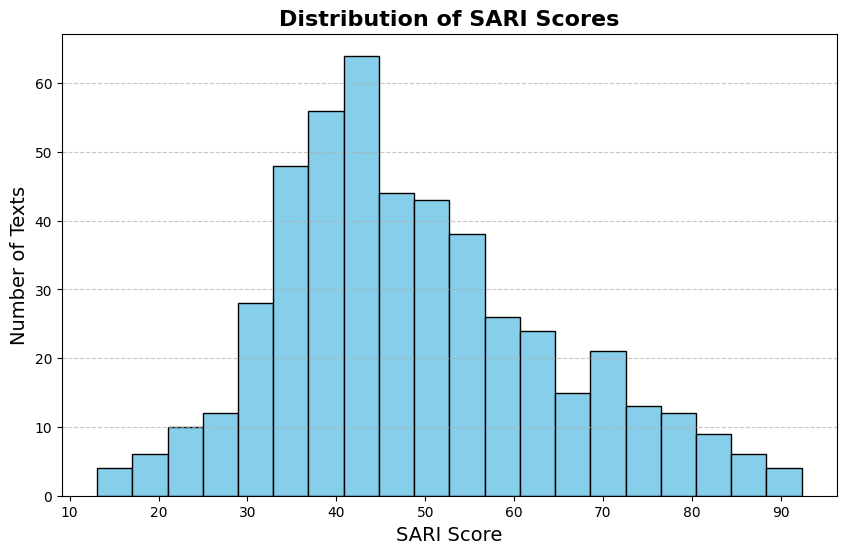

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(sari_scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of SARI Scores', fontsize=16, fontweight='bold')
plt.xlabel('SARI Score', fontsize=14)
plt.ylabel('Number of Texts', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [18]:
import numpy as np

print("Overall SARI score: ", np.mean(sari_scores))

Overall SARI score:  48.83351591353965


## EASSE package SARI

In [30]:
import sys,os
sys.path.append('../easse')

from easse.sari import corpus_sari


sari_scores_easse = []

for index, row in tqdm(df_results.iterrows(), total=len(df_results)):
    r_content = row['text'] 
    s_content = row['reference']  
    prediction = row['prediction']  
    
    sari_score = corpus_sari(
        orig_sents=[r_content],
        sys_sents=[prediction],
        refs_sents=[[s_content]] 
    )
    
    sari_scores_easse.append(sari_score)

100%|██████████████████████████████████████████| 483/483 [00:00<00:00, 542.78it/s]


In [31]:
df = pd.DataFrame({
    'text': swipe_dataset['test_id']['r_content'],
    'reference': swipe_dataset['test_id']['s_content'],
    'prediction': predictions,
    'sari_score': sari_scores_easse
})

df.to_csv("../data/bart-large-swipe_sari_easse-adam-paged8bit.csv", index=False)

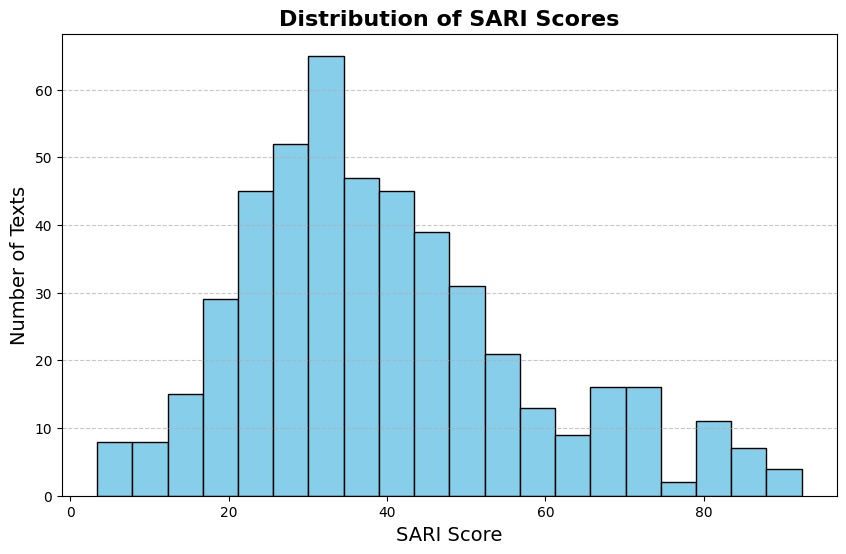

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(sari_scores_easse, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of SARI Scores', fontsize=16, fontweight='bold')
plt.xlabel('SARI Score', fontsize=14)
plt.ylabel('Number of Texts', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [33]:
import numpy as np

print("Overall SARI score: ", np.mean(sari_scores_easse))

Overall SARI score:  39.64759954078891


# Save model

In [21]:
generation_config.save_pretrained("../models/bart-swipe/model")
model.save_pretrained("../models/bart-swipe/model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


# Inspect results

In [19]:
references[1]

'Russian (русский язык (russkij yazyk)) is the most widely spoken of the Slavic languages. Russian is the official language of Russia, and an official language of Belorussia, Kazakhstan and Kyrgyzstan. Russian is one of the five official languages of the United Nations. People were encouraged to speak Russian in the former Soviet Union, but now, many countries that were once part of the Soviet Union speak a local language.'

In [20]:
predictions[1]

'Russian (Russkij yazyk, Русский язык) is the most widely spoken of the Slavic languages. It is primarily spoken in Russia and other nations of the former Soviet Union, and was also widely taught in schools in member countries of the Warsaw Pact. In Soviet times, Russian was often strongly promoted to the detriment of other local languages. While many of the countries in the former USSR are now promoting their local languages rather than Russian, Russian remains widely spoken in these areas and is often used for intercommunication between these countries. Russian is written using the Cyrillic alphabet. Russenorsk is a pidgin language combining Russian and Norwegian.'

## Low SARI scores

Texts almost without simplification, where a huge part of original text was deleted.

Main traits: very long texts (over 512 characters)

In [22]:
df_to_check = df[df['sari_score']<20]
print('Num of records: ', len(df_to_check))

Num of records:  10


In [23]:
for idx, row in df_to_check.iterrows():
    print("ID: ", idx)
    print("Text: ")
    print(row['text'], end='\n\n')
    print("Reference:")
    print(row['reference'], end='\n\n')
    print("Simplification: ")
    print(row['prediction'], end='\n\n')
    display(HTML(highlight_diff(row['text'],row['prediction'])))
    print('\n\n')

ID:  51
Text: 
Masoud Barzani (Kurdish: مەسعوود بارزانی or Mesûd Barzanî; born 16 August 1946) is a Kurdish politician who has been President of the Iraqi Kurdistan Region since 2005. However, Barzani’s post has sparked controversy, as his tenure expired 19 August 2015. He is also leader of the Kurdistan Democratic Party (KDP) since 1979. Masoud Barzani succeeded his father, the Kurdish nationalist leader Mustafa Barzani, as the leader of the KDP in 1979. Working closely with his brother Idris Barzani until Idris's death, Barzani and various other Kurdish groups fought the forces of the Iraqi government in Baghdad during the Iran–Iraq War. For much of this time, the Kurdish leadership was exiled to Iran. Barzani was born in Iranian Kurdistan, during the short-lived Republic of Mahabad.

Reference:
Massoud Barzani (born 16 August 1946) was the first president of Iraqi Kurdistan. He became President on 14 June 2005. Masoud Barzani succeeded his father, the Kurdish nationalist leader Must




ID:  148
Text: 
South Sudan, officially the Republic of South Sudan, is a country in East Africa. Its capital and largest city is Juba, located in the southern state of Central Equatoria. The landlocked country is bordered by Ethiopia to the east; Kenya to the southeast; Uganda to the south; the Democratic Republic of the Congo to the southwest; and the Central African Republic to the west; and the Republic of Sudan to the north. South Sudan includes the vast swamp region of the Sudd formed by the White Nile, locally called the Bahr al Jabal. What is now South Sudan was initially part of the British and Egyptian condominium of Anglo-Egyptian Sudan and became part of the Republic of Sudan when independence was achieved in 1956. Following the First Sudanese Civil War, the Southern Sudan Autonomous Region was formed in 1972 and lasted until 1983. A second Sudanese civil war soon developed and ended with the Comprehensive Peace Agreement of 2005. Later that year, southern autonomy was r




ID:  150
Text: 
The Phasmatodea (sometimes called Phasmida) are an order of insects, whose members are variously known as stick insects (in Europe and Australasia), walking sticks or stick-bugs (in the United States and Canada), phasmids, ghost insects and leaf insects (generally the family Phylliidae). The ordinal name is derived from the Ancient Greek φάσμα phasma, meaning an apparition or phantom, and refers to the resemblance of many species to sticks or leaves. Their natural camouflage can make them extremely difficult to spot. Phasmatodea can be found all over the world in warmer zones, especially the tropics and subtropics. The greatest diversity is found in Southeast Asia and South America, followed by Australia. Phasmids also have a considerable presence in the continental United States, mainly in theSoutheast.

Reference:
The Phasmatodea (sometimes called Phasmida) are an order of insects which include the stick insects and leaf insects. They are all mimics. The name comes




ID:  197
Text: 
The Papahānaumokuākea Marine National Monument (or often Northwestern Hawaiian Islands Marine National Monument) is a World Heritage listed, U.S. National Monument encompassing 140,000 square miles (360,000 km2) (an area larger than the country of Greece) of ocean waters, including ten islands and atolls of the Northwestern Hawaiian Islands, internationally recognized for both its cultural and natural values as follows:

Reference:
The Papahānaumokuākea Marine National Monument is a World Heritage site. It is often called Northwestern Hawaiian Islands Marine National Monument. The site covers 140,000 square miles (360,000 km2) of ocean waters that includes ten islands and atolls. The size is larger than the country of Greece. The area was made a national monument by U.S. President George W. Bush on June 15, 2006. It became a World Heritage site on July 30, 2010. Papahānaumokuākea supports 7,000 species. One quarter of the species are endemic.

Simplification: 
The Pa




ID:  199
Text: 
"Jabberwocky" is a nonsense poem written by Lewis Carroll in his 1871 novel Through the Looking-Glass, and What Alice Found There, a sequel to Alice's Adventures in Wonderland. The book tells of Alice's adventures within the back-to-front world of a looking glass. In an early scene in which she first encounters the chess piece characters White King and White Queen, Alice finds a book written in a seemingly unintelligible language. Realising that she is travelling through an inverted world, she recognises that the verse on the pages are written in mirror-writing. She holds a mirror to one of the poems, and reads the reflected verse of "Jabberwocky". She finds the nonsense verse as puzzling as the odd land she has passed into, later revealed as a dreamscape. "Jabberwocky" is considered one of the greatest nonsense poems written in English. Its playful, whimsical language has given us nonsense words and neologisms such as "galumphing" and "chortle". And then there was a




ID:  234
Text: 
Seleucus I Nicator[A] (c. 358 BC – 281 BC) (Ancient Greek: Σέλευκος Α΄ Νικάτωρ) was one of the Diadochi.[B] Having previously served as an infantry general under Alexander the Great, he eventually assumed the title of basileus[C] and established the Seleucid Empire over much of the territory in the Near East which Alexander had conquered. After the death of Alexander in June 323 BC, Seleucus initially supported Perdiccas, the regent of Alexander's empire, and was appointed Commander of the Companions and chiliarch at the Partition of Babylon in 323 BC. However, after the outbreak of the Wars of the Diadochi in 322, Perdiccas' military failures against Ptolemy in Egypt led to the mutiny of his troops in Pelusium. Perdiccas was betrayed and assassinated in a conspiracy by Seleucus, Peithon and Antigenes in Pelusium sometime in either 321 or 320 BC. At the Partition of Triparadisus in 321 BC, Seleucus was appointed Satrap of Babylon under the new regent Antipater. But a




ID:  258
Text: 
Grossaffoltern is a municipality in the Seeland administrative district in the canton of Bern in Switzerland. It is known for its stork colony.

Reference:
Grossaffoltern is a municipality in the administrative district of Seeland in the canton of Bern in Switzerland.

Simplification: 
Grossaffoltern is a municipality of the Seeland administrative district in the canton of Berne in Switzerland. It is known for its stork colony. The population in 2018 was 1,908. The municipality is located in the region Seeland.






ID:  262
Text: 
A scripting or script language is a programming language that supports scripts, programs written for a special run-time environment that automate the execution of tasks that could alternatively be executed one-by-one by a human operator. Scripting languages are often interporeted (rather than compiled). Primitives are usually the elementary tasks or API calls, and the language allows them to be combined into more complex programs. Environments that can be automated through scripting include software applications, web pages within a web browser, the shells of operating systems (OS), embedded systems, as well as numerous games. A scripting language can be viewed as a domain-specific language for a particular environment; in the case of scripting an application, this is also known as an extension language. Scripting languages are also sometimes referred to as very high-level programming languages, as they operate at a high level of abstraction, or as control languages, 




ID:  284
Text: 
Myopathy is a disease of the muscles in which the muscle fibers do not function properly. This results in muscular weakness. "Myopathy" simply means muscle disease (Greek myo- "muscle" + patheia < -pathy "suffering"). This meaning implies that the primary defect is within the muscle, as opposed to the nerves ("neuropathies" or "neurogenic" disorders) or elsewhere (e.g., the brain). Muscle cramps, stiffness, and spasm can also be associated with myopathy. Muscular disease can be classified as neuromuscular or musculoskeletal in nature. Some conditions, such as myositis, can be considered both neuromuscular and musculoskeletal.

Reference:
Myopathy is a disease of the muscle in which the muscle fibers do not function properly. This results in muscular weakness. "Myopathy" simply means muscle disease (Greek myo- "muscle" + patheia < -pathy "suffering"). This meaning implies that the primary defect is within the muscle, as opposed to the nerves ("neuropathies" or "neurog




ID:  393
Text: 
The CMYK color model (also known as process color, or four color) is a subtractive color model, based on the CMY color model, used in color printing, and is also used to describe the printing process itself. CMYK refers to the four ink plates used in some color printing: cyan, magenta, yellow, and key (black). The CMYK model works by partially or entirely masking colors on a lighter, usually white, background. The ink reduces the light that would otherwise be reflected. Such a model is called subtractive because inks "subtract" the colors red, green and blue from white light. White light minus red leaves cyan, white light minus green leaves magenta, and white light minus blue leaves yellow. In additive color models, such as RGB, white is the "additive" combination of all primary colored lights, black is the absence of light. In the CMYK model, it is the opposite: white is the natural color of the paper or other background, black results from a full combination of col

## Medium SARI scores

Main operations: copy, delete and minimal insertion

Main traits: medium-length texts

In [24]:
df_to_check = df[(df['sari_score']>48) & (df['sari_score']<49)]
print('Num of records: ', len(df_to_check))

Num of records:  6


In [25]:
for idx, row in df_to_check.iterrows():
    print("ID: ", idx)
    print("Text: ")
    print(row['text'], end='\n\n')
    print("Reference:")
    print(row['reference'], end='\n\n')
    print("Simplification: ")
    print(row['prediction'], end='\n\n')
    display(HTML(highlight_diff(row['text'],row['prediction'])))
    print('\n\n')

ID:  210
Text: 
Sir Reginald Oswald Palmer, GCMG, (born 15 February 1923) was the governor-general of Grenada from 6th August 1992 to 8th August 1996. Beginning his career in education, first as a pupil teacher he went on to become the head teacher of St. George's Roman Catholic School in 1956. In 1972 he was promoted to the government post of Assistant Education Officer and then in 1973 was made Principal of the Grenada Teacher's College. The following year he was again promoted, becoming the government Chief Education Officer. Palmer retired from public service in 1980 and entered the private sector, serving two terms as President of the Grenada Employer's Federation.

Reference:
Sir Reginald Oswald Palmer, GCMG, (born 15 February 1923) was the governor-general of Grenada from 6 August 1992 to 8 August 1996. Palmer retired from public service in 1980 and entered the private sector, serving two terms as President of the Grenada Employer's Federation.

Simplification: 
Sir Reginald Osw




ID:  248
Text: 
The Roland Alpha Juno series of keyboards are analog polyphonic synthesizers with a digitally controlled oscillator manufactured by Roland Corporation in 1985 to 1986. Two models were released: the Alpha Juno 1 (JU-1) (1985-1986), and the Alpha Juno 2 (JU-2) (1985-1986), which added one octave of notes, a cartridge slot and touch-sensitivity. Alpha Juno synthesizers were notable for their reduced user interface compared to other synths of the day, with a single Alpha Dial replacing many sliders and knobs. The keyboard features MIDI in, out and thru, mono, stereo and headphone sockets. It also supports an external footpedal controller, and tape backup. The MKS-50 (1986) is a rack-mount version of the Alpha Juno. It has the same synth engine and architecture, with some added features like 16 programmable chord memories, the ability to store velocity, volume, panning, de-tune, portamento and other similar parameters within each patch you create. The Alpha Juno is notabl




ID:  280
Text: 
There have been 50 total women in the United States Senate since its establishment in 1789. The first woman senator, Rebecca Felton, served in 1922 (for a single day), but the first woman elected to the Senate was Hattie Caraway in 1932. Fourteen of the women who have served were appointed; seven of those were appointed to succeed their deceased husbands. Currently (as of 2017), the 115th Congress has 21 female senators out of 100 (21%), one more than both the 113th and 114th congresses, and an all-time high.

Reference:
There have been 50 women in the United States Senate since it started in 1789. Rebecca Felton was the first. She was in the Senate for one day in 1922. Hattie Caraway was the first woman elected to the Senate in 1932. Fourteen of the women Senators were not elected. They were appointed. Seven of them were appointed to replace their dead husbands. In 2017 there are 21 female senators out of 100. That is the largest number of women in the Senate at the




ID:  289
Text: 
Barbara Knox MBE (born 30 September 1933), is a British actress, known for her portrayal of newsagent Rita Tanner in the television soap opera Coronation Street. She has been a full-time cast member for over 45 years, having appeared for one episode as Rita in 1964, before becoming a regular cast member from 1972 onwards. Knox made her professional stage debut in 1962 at the Oldham Coliseum Theatre, had a small role as a dancer in the 1969 remake of Goodbye Mr. Chips and appeared opposite Ken Dodd in his 1972 comedy series Funny You Should Say That. She won the 1989 TV Times Award for Best Actress for one of her best remembered storylines, involving the Alan Bradley character. In 2006, she won the British Soap Award for Best On-Screen Partnership with Malcolm Hebden, having previously received the Lifetime Achievement Award at the 2004 ceremony. She was made an MBE in the 2010 Queen's Birthday Honours.

Reference:
Barbara Knox MBE (born 30 September 1933), is a Briti




ID:  391
Text: 
BMO Field is an outdoor stadium located at Exhibition Place in Toronto, Ontario, Canada, which is home to Toronto FC of Major League Soccer and the Toronto Argonauts of the Canadian Football League. Constructed on the site of the former Exhibition Stadium and first opened in 2007, it is owned by the City of Toronto, and managed by Maple Leaf Sports & Entertainment. The stadium's naming rights are held by the Bank of Montreal, which is commonly branded as "BMO" (/ˈbiːmoʊ/). BMO Field was originally constructed as a soccer-specific stadium to serve as the home field of the expansion Toronto FC, and hosted matches during the 2007 FIFA U-20 World Cup and 2014 FIFA U-20 Women's World Cup. In 2010, when it was still a neutral-site game, BMO Field hosted the MLS Cup. It has since hosted the 2016 and 2017 finals featuring Toronto FC, under the current practice of giving home field advantage to the side with the better regular season record. The venue has also hosted rugby un




ID:  481
Text: 
hkljg Count von Count (known simply as the Count) is a mysterious but friendly vampire Muppet on the long-running PBS/HBO children's television show Sesame Street who is meant to parody Bela Lugosi's portrayal of Count Dracula. He first appeared on the show in the Season 4 premiere in 1972, counting blocks in a sketch with Bert and Ernie.

Reference:
Count von Count (known simply as the Count) is a mysterious but friendly vampire Muppet on the long-running PBS/HBO children's television showSesame Street who is meant to parody Bela Lugosi's portrayal of Count Dracula. He first appeared on the show in the Season 4 premiere in 1972, counting blocks in a sketch with Bert and Ernie.

Simplification: 
Count von Count (known simply as the Count) is a mysterious but friendly vampire Muppet on the long-running PBS/HBO children's television show Sesame Street. He is meant to parody Bela Lugosi's portrayal of Count Dracula. He first appeared on the show in the Season 4 premiere

## High SARI scores

Main operations: insertion, copy, deletion

Main traits: very short texts

In [26]:
df_to_check = df[df['sari_score']>90]
print('Num of records: ', len(df_to_check))

Num of records:  4


In [27]:
for idx, row in df_to_check.iterrows():
    print("ID: ", idx)
    print("Text: ")
    print(row['text'], end='\n\n')
    print("Reference:")
    print(row['reference'], end='\n\n')
    print("Simplification: ")
    print(row['prediction'], end='\n\n')
    display(HTML(highlight_diff(row['text'],row['prediction'])))
    print('\n\n')

ID:  87
Text: 
Boëssé-le-Sec is a commune in the Sarthe department in the region of Pays-de-la-Loire in northwestern France.

Reference:
Boëssé-le-Sec is a commune. It is found in the region Pays de la Loire in the Sarthe department in the west of France.

Simplification: 
Boëssé-le-Sec is a commune. It is found in the region Pays de la Loire in the Sarthe department in the west of France. In 2018, 1,819 people lived there.






ID:  99
Text: 
Asnières-en-Bessin is a commune in the Calvados department in the Basse-Normandie region in northwestern France.

Reference:
Asnières-en-Bessin is a commune. It is found in the region Basse-Normandie in the Calvados department in the northwest of France.

Simplification: 
Asnières-en-Bessin is a commune. It is found in the region Basse-Normandie in the Calvados department in the northwest of France. In 2018, 1,819 people lived there.






ID:  104
Text: 
Saint-Germain-de-Livet is a commune in the Calvados department in the Basse-Normandie region in northwestern France.

Reference:
Saint-Germain-de-Livet is a commune. It is found in the region Basse-Normandie in the Calvados department in the northwest of France.

Simplification: 
Saint-Germain-de-Livet is a commune. It is found in the region Basse-Normandie in the Calvados department in the northwest of France. In 2018, 1,819 people lived there.






ID:  380
Text: 
Saint-Ségal (Breton: Sant-Segal) is a commune in the Finistère department of Brittany in north-western France.

Reference:
Saint-Ségal (Breton: Sant-Segal) is a commune. It is found in the region Brittany in the Finistère department in the northwest of France.

Simplification: 
Saint-Ségal (Breton: Sant-Segal) is a commune. It is found in the region Brittany in the Finistère department in the northwest of France. In 2018, 1,819 people lived there.

